<a href="https://colab.research.google.com/github/MichaelTay/w281-summer-2023-project/blob/main/W281_Project_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

mountdir = '/content/drive/'
drive.mount(mountdir, force_remount=True)

localdir = mountdir + 'MyDrive'
w281_dir = '/Berkeley/w281/Fruit-and-Vegetable-Classification/modeling/'
modeling_dir = localdir + w281_dir


Mounted at /content/drive/


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os.path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_curve,
                             auc, RocCurveDisplay,
                             classification_report,
                             confusion_matrix,accuracy_score)
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score, f1_score, make_scorer, ConfusionMatrixDisplay
from sklearn.utils import shuffle

from hyperopt import tpe, atpe, rand, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
from tqdm import tqdm

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

data_dir = 'drive/MyDrive/Berkeley/w281/Fruit-and-Vegetable-Classification/modeling/pca_datasets/'

In [24]:
## Learning Curve
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [6]:
!ls drive/MyDrive/Berkeley/w281/Fruit-and-Vegetable-Classification/modeling/pca_datasets/

test_daisy_lum_sat_hue.csv	validation_daisy_lum_sat_hue.csv
training_daisy_lum_sat_hue.csv


## Modeling

##### Features: <br> Daisy, Hue, Saturation, Luminance, HOG, Laplacian.

In [10]:
train = pd.read_csv(data_dir + 'training_daisy_lum_sat_hue.csv').drop('Unnamed: 0', axis=1)
validation = pd.read_csv(data_dir + 'validation_daisy_lum_sat_hue.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv(data_dir + 'test_daisy_lum_sat_hue.csv').drop('Unnamed: 0', axis=1)

##### Bayesian Parameter Search

In [12]:
space = {
    'C' : hp.loguniform('C', low=-4*np.log(10), high=4*np.log(10)),
    'fit_intercept' : hp.choice('fit_intercept', [True, False]),
    'max_iter': hp.choice('max_iter', range(100, 1000)),
    'solver': hp.choice('solver', ['newton-cg','sag','liblinear','saga'])
}

In [19]:
def optimize_lr(params):

    skf = StratifiedKFold(n_splits=5)
    clf = LogisticRegression(**params, n_jobs=-1)
    cv_accuracy = cross_val_score(clf, train.iloc[:, 0:-1], train.iloc[:,-1],
                         scoring=make_scorer(accuracy_score),
                        cv=skf).mean()
    best_score = np.mean(cv_accuracy)
    loss = 1 - best_score
    return {"loss":loss, "status":STATUS_OK}

In [20]:
RANDOM_SEED = 4321
trials = Trials()

best = fmin(
    fn=optimize_lr,
    space=space,
    # algo=rand.suggest,
    # algo=atpe.suggest,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(RANDOM_SEED)
)

print("Best: {}".format(best))

100%|██████████| 100/100 [09:55<00:00,  5.96s/trial, best loss: 0.8338762214983713]
Best: {'C': 0.0002812101267655913, 'fit_intercept': 0, 'max_iter': 893, 'solver': 0}


#### Learning Curve

In [22]:
LR_clf = LogisticRegression(
    C=0.0002812101267655913,
    fit_intercept=True,
    max_iter=893,
    solver='newton-cg',
    random_state=RANDOM_SEED
)

X_train, y_train = train.iloc[:,0:-1], train.iloc[:, -1]

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

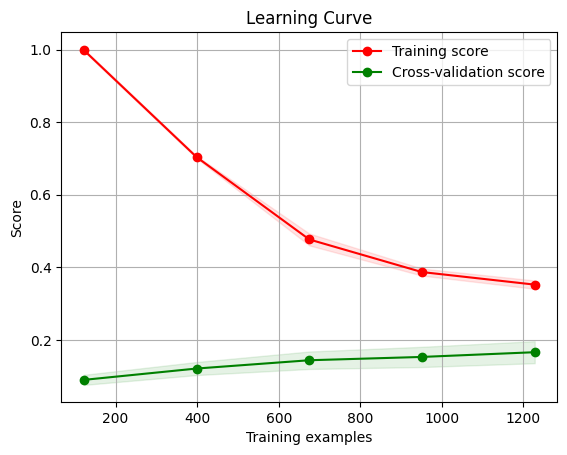

In [25]:
# Plot the learning curve
plot_learning_curve(LR_clf, X_train, y_train, cv=5)

#### Predict on Validation Set

In [27]:
X_val, y_val = validation.iloc[:, 0:-1], validation.iloc[:, -1]

params = {
    'C':0.0002812101267655913,
    'fit_intercept': True,
    'max_iter': 893,
    'solver': 'newton-cg',
    'random_state':RANDOM_SEED
}
LR_clf = LogisticRegression(**params, n_jobs=-1)

LR_clf.fit(train.iloc[:,0:-1], train.iloc[:,-1])

y_pred = LR_clf.predict(X_val)

print(accuracy_score(y_val, y_pred))

0.4919786096256685


In [28]:
print(classification_report(y_val, y_pred))

               precision    recall  f1-score   support

        apple       0.50      0.33      0.40         9
       banana       0.55      0.67      0.60         9
  bell pepper       0.55      0.67      0.60         9
      cabbage       0.40      0.40      0.40        10
  cauliflower       0.78      0.78      0.78         9
chilli pepper       0.33      0.14      0.20         7
         corn       0.67      0.40      0.50        10
       garlic       0.38      0.50      0.43        10
       ginger       0.67      0.40      0.50        10
       grapes       0.43      0.38      0.40         8
         kiwi       0.70      0.70      0.70        10
        mango       0.45      0.50      0.48        10
       orange       0.17      0.14      0.15         7
         pear       0.50      0.80      0.62        10
         peas       0.42      0.56      0.48         9
    pineapple       0.58      0.70      0.64        10
  pomegranate       0.75      0.60      0.67        10
      spi

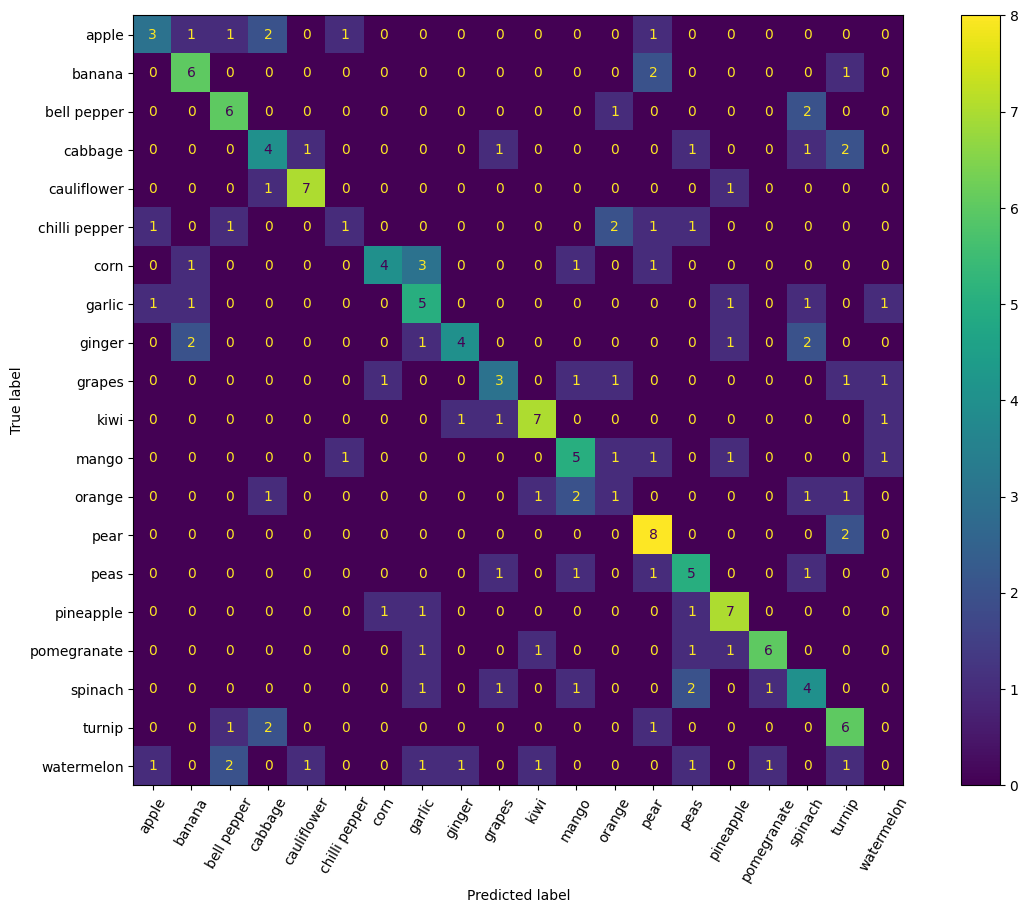

In [29]:
fig, ax = plt.subplots(figsize=(15,10))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, xticks_rotation=60, ax=ax)